In [24]:
import numpy as np
import json
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
import hist
from hist import Hist
# import mplhep as hep
# import matplotlib.pyplot as plt
import pandas as pd

In [44]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass
    def process(self, events):
        dataset = events.metadata["dataset"]

        results={}
        results[dataset]={
            "count": len(events)
        }
            
        # define the histogram
        h = (
            Hist.new.StrCat([], growth=True, name="dataset", label="Primary dataset")
            .Reg(100, 60, 120, overflow=False, underflow=False, name="x", label = r"m$_{\gamma \gamma}$ [GeV]")
            .Weight()
        )

        h_eta_lead = (
            Hist.new
            .StrCat([], growth=True, name="dataset", label="Primary dataset")
            .Reg(100, -2.5, 2.5, overflow=False, underflow=False, name="x", label = r"m$_{\gamma \gamma}$ [GeV]")
            .Weight()
        )

        h_eta_sublead = (
            Hist.new
            .StrCat([], growth=True, name="dataset", label="Primary dataset")
            .Reg(100, -2.5, 2.5, overflow=False, underflow=False, name="x", label = r"m$_{\gamma \gamma}$ [GeV]")
            .Weight()
        )

        h_pt_lead = (
            Hist.new.StrCat([], growth=True, name="dataset", label="Primary dataset")
            .Reg(100, 30, 90, overflow=False, underflow=False, name="x", label = r"m$_{\gamma \gamma}$ [GeV]")
            .Weight()
            )
        
        h_pt_sublead = (
            Hist.new.StrCat([], growth=True, name="dataset", label="Primary dataset")
            .Reg(100, 30, 90, overflow=False, underflow=False, name="x", label = r"m$_{\gamma \gamma}$ [GeV]")
            .Weight()
            )

        # data_kind = "mc" if "GenPart" in ak.fields(events) else "data"

        electrons = events.Electron.mask[events.HLT.Ele32_WPTight_Gsf] 

        # get electrons

        # add selections
        count_number_of_electorn = ak.num(electrons, axis=1)
        
        # select electrons more than one
        electrons_masked = electrons.mask[count_number_of_electorn > 1]
        
        # tag tight cut electron based ID
        cutBased = electrons_masked.cutBased[:,0]
        electrons_masked = electrons_masked.mask[cutBased == 4]

        # select eta
        abs_eta = np.abs(electrons_masked.eta)
        electrons_masked = electrons_masked.mask[(abs_eta < 1.4442) | (abs_eta > 1.566) & (abs_eta < 2.1)]
        
        # select pt
        electrons_masked = electrons_masked.mask[
            (electrons_masked.pt[:,0] > 35)
            # (electrons_masked.pt[:,1] > 25)
        ]

        # save only the events passing the selections
        total_selection = ak.fill_none(
            ak.num(electrons_masked,axis=1) == 2,
            False
        )

        electrons_selected = electrons_masked[total_selection]

        # make sure the dielectron is e+ and e-
        charge = ak.sum(electrons_selected.charge, axis=1) == 0
        # make the dielectron pair combinations
        dielectron_pairs = ak.combinations(electrons_selected[charge], 2, fields=["lead", "sublead"])

        # dielectron four-momentum
        dielectrons = dielectron_pairs.lead+dielectron_pairs.sublead

        h.fill(dataset=dataset,x=dielectrons.mass[:,0])

        h_eta_lead.fill(dataset=dataset, x=dielectron_pairs.lead.eta[:,0])
        h_eta_sublead.fill(dataset=dataset, x=dielectron_pairs.sublead.eta[:,0])
        
        h_pt_lead.fill(dataset=dataset, x=dielectron_pairs.lead.pt[:,0])
        h_pt_sublead.fill(dataset=dataset, x=dielectron_pairs.sublead.pt[:,0])

        results["mass"] = h
        results["eta_lead"] = h_eta_lead
        results["eta_sublead"] = h_eta_sublead
        results["pt_lead"] = h_pt_lead
        results["pt_sublead"] = h_pt_sublead
        return results

    def postprocess(self, accumulant):
        pass

In [26]:
samplejson = "/eos/home-h/hhsieh/hsinyeh/TagAndProbe/configs/TnP_2018_1.json"
with open(samplejson) as f:
        sample_dict = json.load(f)

In [45]:
run = processor.Runner(
    # executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(workers=10), # user 4 cores
    schema=NanoAODSchema
)

results = run(
    sample_dict,
    treename="Events",
    processor_instance=MyProcessor(),
)



Output()

In [37]:
results

{'DY_70to100': {'count': 1720969},
 'mass': Hist(
   StrCategory(['DY_70to100', 'DY_100to200', 'DataA_2018'], growth=True, name='dataset', label='Primary dataset'),
   Regular(100, 60, 120, underflow=False, overflow=False, name='x', label='m$_{\\gamma \\gamma}$ [GeV]'),
   storage=Weight()) # Sum: WeightedSum(value=201373, variance=201373),
 'eta_lead': Hist(
   StrCategory(['DY_70to100', 'DY_100to200', 'DataA_2018'], growth=True, name='lead', label='Primary dataset'),
   Regular(100, -2.5, 2.5, underflow=False, overflow=False, name='x', label='m$_{\\gamma \\gamma}$ [GeV]'),
   storage=Weight()) # Sum: WeightedSum(value=215201, variance=215201),
 'eta_sublead': Hist(
   StrCategory(['DY_70to100', 'DY_100to200', 'DataA_2018'], growth=True, name='sublead', label='Primary dataset'),
   Regular(100, -2.5, 2.5, underflow=False, overflow=False, name='x', label='m$_{\\gamma \\gamma}$ [GeV]'),
   storage=Weight()) # Sum: WeightedSum(value=215201, variance=215201),
 'pt_lead': Hist(
   StrCateg

In [38]:
set(sample_dict.keys())

{'DY_100to200', 'DY_70to100', 'DataA_2018'}

In [39]:
datasets_Data = [key for key in sample_dict if key.startswith("Data")]
datasets_DY = [key for key in sample_dict if key.startswith("DY")]

In [42]:
variables = ["mass","pt_lead","pt_sublead","eta_lead","eta_sublead"]

In [46]:
for variable in variables:
    Data_hist = sum(results[variable][{"dataset":dataset_Data}] for dataset_Data in datasets_Data)
    Data_values = Data_hist.values()
    edges_Data = Data_hist.axes.edges
    Data={
        'Data_bin_center':[(edges_Data[0][i] + edges_Data[0][i+1]) / 2 for i in range(len(edges_Data[0])-1)],
        'Data_count':Data_values,
    }
    df_Data = pd.DataFrame(data=Data)
    df_Data.to_parquet(f'parquet/Data_{variable}.parquet')

In [47]:
df_Data

,Data_bin_center,Data_count
0,-2.475,0.0
1,-2.425,0.0
2,-2.375,0.0
3,-2.325,0.0
4,-2.275,0.0
...,...,...
95,2.275,0.0
96,2.325,0.0
97,2.375,0.0
98,2.425,0.0


In [48]:
for variable in variables:
    DY_hist = sum(results[variable][{"dataset":dataset_DY}] for dataset_DY in datasets_DY)
    DY_values = DY_hist.values()
    edges_Data = Data_hist.axes.edges
    edges_DY = DY_hist.axes.edges 
    DY={
        'DY_bin_center':[(edges_DY[0][i] + edges_DY[0][i+1]) / 2 for i in range(len(edges_DY[0])-1)],
        'DY_count':DY_values,
    }
    df_DY = pd.DataFrame(data=DY)
    df_DY.to_parquet(f'parquet/DY_{variable}.parquet')

In [11]:
Data_hist= results["mass"][{"dataset":"DataA_2018"}]
DY_hist= results["mass"][{"dataset":"DY_70to100"}] + results["mass"][{"dataset":"DY_100to200"}]

Data_values = Data_hist.values()
DY_values = DY_hist.values()

edges_Data = Data_hist.axes.edges
edges_DY = DY_hist.axes.edges 

print(DY_hist.values())


[  7269.   7396.   7434.   7284.   7395.   7414.   7600.   7668.   7827.
   7984.   7838.   8135.   8284.   8497.   8643.   8924.   9070.   9425.
   9580.  10026.  10363.  10655.  11452.  11511.  12260.  12970.  13498.
  14806.  15409.  17145.  17914.  19279.  21266.  23400.  25397.  28623.
  32017.  36290.  41742.  48131.  55882.  65511.  78531.  94018. 113477.
 137990. 167149. 202099. 239881. 275720. 304605. 313368. 300214. 263569.
 218733. 173708. 134032. 103047.  79381.  61060.  48282.  38440.  31176.
  26013.  21665.  18637.  15967.  13829.  12493.  11155.  10076.   8884.
   8054.   7526.   6973.   6498.   5941.   5623.   5196.   4884.   4566.
   4391.   4074.   3975.   3723.   3508.   3348.   3336.   3033.   3011.
   2836.   2747.   2610.   2563.   2435.   2415.   2359.   2231.   2155.
   2135.]


In [13]:
Data_hist= results["mass"][{"dataset":"DataA_2018"}]
DY_hist= results["mass"][{"dataset":"DY_70to100"}] + results["mass"][{"dataset":"DY_100to200"}]

Data_values = Data_hist.values()
DY_values = DY_hist.values()

edges_Data = Data_hist.axes.edges
edges_DY = DY_hist.axes.edges 

Data={
    'Data_bin_center':[(edges_Data[0][i] + edges_Data[0][i+1]) / 2 for i in range(len(edges_Data[0])-1)],
    'Data_count':Data_values,
}

DY={
    'DY_bin_center':[(edges_DY[0][i] + edges_DY[0][i+1]) / 2 for i in range(len(edges_DY[0])-1)],
    'DY_count':DY_values,
}
    
df_Data = pd.DataFrame(data=Data)
df_DY = pd.DataFrame(data=DY)

df_Data.to_parquet('Data.parquet')
df_DY.to_parquet('DY.parquet')

In [8]:
# df_Data

,Data_bin_ceter,Data_count
0,60.3,3.0
1,60.9,11.0
2,61.5,6.0
3,62.1,6.0
4,62.7,3.0
...,...,...
95,117.3,3.0
96,117.9,4.0
97,118.5,3.0
98,119.1,7.0


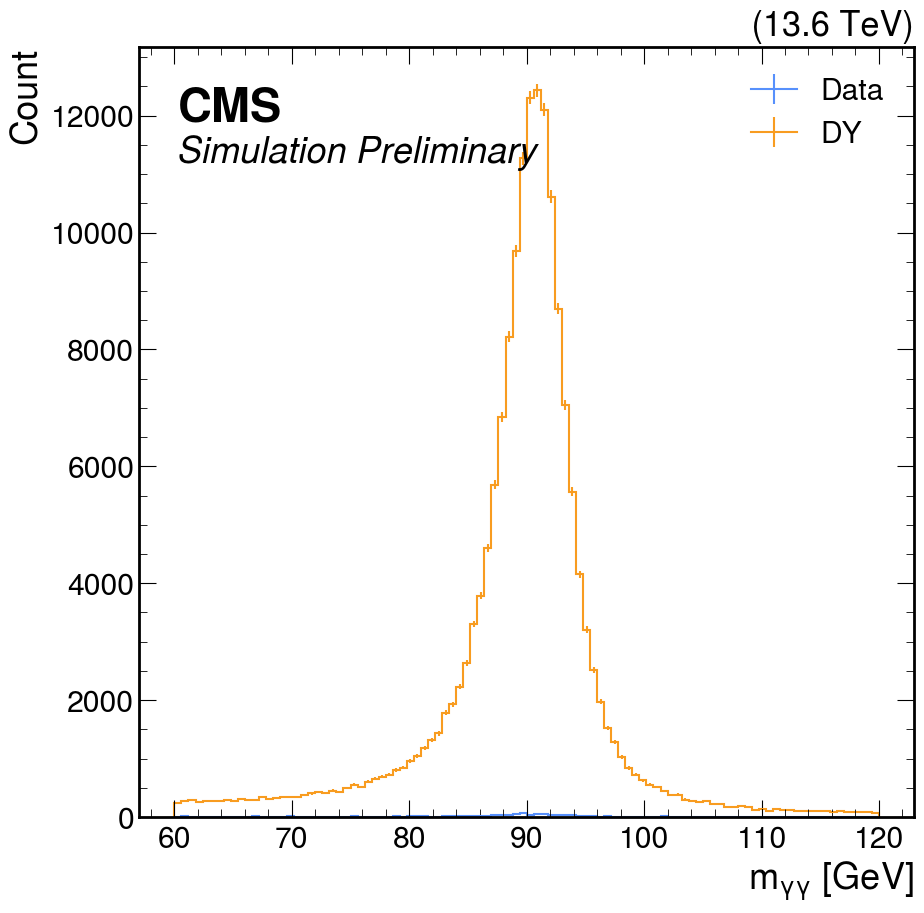

In [19]:
hep.style.use(hep.style.CMS)

f, ax = plt.subplots(figsize=(10,10))

ax.set_ylabel("Count")
results["mass"][{"dataset":"Data"}].plot(ax=ax,label="Data")
results["mass"][{"dataset":"DY"}].plot(ax=ax,label="DY")

hep.cms.label("Preliminary",loc=2,com=13.6)

# ax.set_yscale("log")
plt.legend()
plt.show()

In [4]:
fname = "root://cms-xrd-global.cern.ch//store/data/Run2018A/EGamma/NANOAOD/02Apr2020-v1/50000/0F8976CC-3DFC-0E4E-B37C-F2A14BC80CCC.root"

events = NanoEventsFactory.from_root(fname,schemaclass=NanoAODSchema).events()

In [5]:
electrons = events.Electron

# add selections
count_number_of_electorn = ak.num(electrons, axis=1)

electrons_masked = electrons.mask[count_number_of_electorn > 1]
electrons_masked = electrons_masked.mask[(np.abs(electrons_masked.eta) < 1.4442) | ((np.abs(electrons_masked.eta) > 1.566) & (np.abs(electrons_masked.eta) < 2.1))]
electrons_masked = electrons_masked.mask[
    (electrons_masked.pt[:,0] > 35)
    # (electrons_masked.pt[:,1] > 25)
]

# save only the events passing the selections
total_selection = ak.fill_none(
    ak.num(electrons_masked,axis=1) == 2,
    False
)

electrons_selected = electrons_masked[total_selection]

# make sure the dielectron is e+ and e-
charge = ak.sum(electrons_selected.charge, axis=1) == 0
# make the dielectron pair combinations
dielectron_pairs = ak.combinations(electrons_selected[charge], 2, fields=["lead", "sublead"])

# dielectron four-momentum
dielectrons = dielectron_pairs.lead+dielectron_pairs.sublead

In [7]:
dielectrons.mass[:10]

<Array [[156], [5.65], ... [74.1], [81.2]] type='10 * option[var * ?float32]'>

In [26]:
print(np.sqrt(dielectrons.t**2 - dielectrons.x**2 - dielectrons.y**2 - dielectrons.z**2))
ak.to_list(dielectrons.mass)

[[156], [5.65], [89.1], [23.4], [31.3], ... [110], [124], [67], [50.7], [92.3]]


/eos/home-h/hhsieh/higgsdna_finalfits_tutorial_24/micromamba_dir/envs/higgs-dna/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


[[155.86767578125],
 [5.653227806091309],
 [89.14629364013672],
 [23.35477066040039],
 [31.34868812561035],
 [104.17163848876953],
 [69.08993530273438],
 [78.61726379394531],
 [74.14362335205078],
 [81.19459533691406],
 [110.48509216308594],
 [49.642906188964844],
 [31.290761947631836],
 [5.996092319488525],
 [204.3186798095703],
 [32.05805206298828],
 [90.11202239990234],
 [90.0886001586914],
 [108.95433044433594],
 [88.00474548339844],
 [17.09469223022461],
 [90.01821899414062],
 [27.763774871826172],
 [1.6578683853149414],
 [81.03614807128906],
 [28.032974243164062],
 [39.81711196899414],
 [59.45622634887695],
 [64.02621459960938],
 [134.5033416748047],
 [28.230358123779297],
 [81.81913757324219],
 [89.89590454101562],
 [107.4406967163086],
 [88.51188659667969],
 [100.13267517089844],
 [79.79576873779297],
 [97.1502914428711],
 [93.16304016113281],
 [72.92914581298828],
 [91.18675231933594],
 [169.96397399902344],
 [52.97734069824219],
 [104.03679656982422],
 [158.67532348632812],
 

In [8]:
print( ak.to_list(dielectron_pairs.sublead.mass[:10]))
ak.to_list(dielectron_pairs.lead.mass[:10])

[[-0.01149749755859375], [-0.0091400146484375], [-0.0136871337890625], [-0.0006875991821289062], [0.001598358154296875], [-0.0216827392578125], [-0.0018072128295898438], [-0.00738525390625], [-0.01309967041015625], [0.00095367431640625]]


[[0.02679443359375],
 [-0.03424072265625],
 [0.01355743408203125],
 [-0.0251007080078125],
 [0.017822265625],
 [-0.00493621826171875],
 [0.01393890380859375],
 [0.035614013671875],
 [0.01336669921875],
 [-0.134033203125]]